# 右左折、カーブ及び車線変更の検出

## 概要

[こちら](https://tagi98.github.io/files/publication/VSense.pdf)の論文を参考に、ルールベースで右左折・カーブ・車線変更を検出する。

## データ準備

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os, pathlib, math, time, sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates

In [2]:
# 使用する特徴量
feat_dict = {
             '1EF37': 'Yaw_Rate',
             '11947': 'Steering_Wheel_Absolute_Angle',
             '31417': 'Vehicle_Speed'
            }

# 読み込み
colname = ['carnumber', 'timestamp_min', 'timestamp_sec', 'feature_name', 'feature_value']
data = pd.read_csv("../data/interim/20190605_CAN/" + 
                 "103.486_CAR1V21_HDD2/Job1/SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
                 header=None,names=colname)

# 使用する特徴量を含むレコードのみ残す
data = data.loc[data['feature_name'].isin(feat_dict.keys()), :]

In [3]:
data.head()

,carnumber,timestamp_min,timestamp_sec,feature_name,feature_value
65,21,201604200627,0.297781,31417,0.000
75,21,201604200627,0.299752,11947,-7.700
124,21,201604200627,0.304361,1EF37,0.025
258,21,201604200627,0.309778,11947,-7.700
474,21,201604200627,0.319752,11947,-7.700


In [4]:
freq = "100L" # リサンプリング単位 = 100 ms
series_sampled_dict = {} # リサンプルされたSeriesの辞書
for feature in feat_dict.keys():
    data_sub = data.loc[data.feature_name == feature] # 対象となるfeatureのレコードのみ抽出
    
    # レコード開始時刻(YYYYMMDD HH:MM)とレコード開始からの経過時刻(sec)を足して、暫定的なTimestampを作成
    # 時刻(datetime型)にそのまま整数を足しても、きれいに計算されない。to_timedeltaを使用して、timedelta型に変更してから足す
    data_sub["timestamp"] = (pd.to_datetime(data_sub["timestamp_min"].astype(str))
                             + pd.to_timedelta(data_sub["timestamp_sec"], unit="s"))
    data_sub.set_index("timestamp", inplace=True)
    series_sampled = data_sub["feature_value"].resample(freq).mean() # リサンプル。平均値で集約。
    series_sampled_dict[feat_dict[feature]] = series_sampled # リストに追加

/Users/localadmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [5]:
data_sampled = pd.DataFrame(series_sampled_dict)

## 右左折/車線変更と思われる旋回を検出

原論文に変更を加え、右左折/車線変更に入ったと判定するヨーレートの閾値$\delta_s$は原論文の2倍の0.1 radian/s, 右左折/車線変更に要する最大ヨーレートの閾値$\delta_h$も原論文の2倍の0.14 radian/sとしている。  
右左折/車線変更に要する最低所要時間を1.5秒、車線変更時の切り返しまでの時間を3秒としているのは原論文どおり。

In [6]:
# 角度で換算
print(f"delta_s {2 * 0.05 * (180 / np.pi):.2f} degree/sec") # (degree/seconds)
print(f"delta_h {2 * 0.07 * (180 / np.pi):.2f} degree/sec") # (degree/seconds)

delta_s 5.73 degree/sec
delta_h 8.02 degree/sec


In [7]:
state = 'No-Bump'
state_2nd = ''
delta_s = 2 * 0.05  * (180 / np.pi) # (degree/seconds)
delta_h = 2 * 0.07 * (180 / np.pi) # (degree/seconds)
TBUMP = 1.5 # seconds
TNEXT_DELAY = 3 # seconds
turn_list = list(np.repeat('Straight',len(data_sampled))) # 初期値は全て直線

for i in range(data_sampled.shape[0]):
    Y  = data_sampled.Yaw_Rate[i] # ヨーレート
    
    # start of 1st bump
    if state == 'No-Bump' and abs(Y) > delta_s:
        state = 'One-Bump'
        start_point_bump1 = i # Record the start point of a possible bump                   
        
    # end of 1st bump
    elif state == 'One-Bump' and abs(Y) < delta_s:
        end_point_bump1 = i # Record the end point of a possible bump
        # bump所要時間
        time_diff = data_sampled.Yaw_Rate.index[end_point_bump1] - data_sampled.Yaw_Rate.index[start_point_bump1]
        
        # bump所要時間が一定時間以上 かつ ヨーレート最大値が一定値以上であれば有効
        if time_diff.total_seconds()>=TBUMP and \
            np.abs(data_sampled.Yaw_Rate[start_point_bump1:end_point_bump1]).max() >= delta_h:                       
            state = 'Waiting-for-Bump' # 有効なbumpであったと判断
            sign_bump1 = np.sign(data_sampled.Yaw_Rate.iloc[start_point_bump1])
        else:
            state = 'No-Bump' # 無効なbump(ノイズなど)であったと判断
            
    elif state == 'Waiting-for-Bump':
        # waiting-for-bumpの待機時間
        Tdwell = data_sampled.Yaw_Rate.index[i] - data_sampled.Yaw_Rate.index[end_point_bump1]
        
        if Tdwell.total_seconds() <= TNEXT_DELAY:
            if abs(Y) > delta_s:
                # same direction -> onother one bump
                if np.sign(Y) == sign_bump1:
                    state = 'One-Bump'
                    start_point_bump1 = i # Record the start point of a possible bump      
                # opposite direction -> two bump (possible lane change)
                else:
                    state = 'Two-Bump'
                    start_point_bump2 = i 
        
        # end of waiting-for-bump
        else:
            if data_sampled.Yaw_Rate[start_point_bump1] > 0:
                # left turn
                turn_list[start_point_bump1:end_point_bump1] = \
                    np.repeat('Left_Turn',end_point_bump1-start_point_bump1)
            else:
                # right turn
                turn_list[start_point_bump1:end_point_bump1] = \
                    np.repeat('Right_Turn',end_point_bump1-start_point_bump1)
            state = 'No-Bump'
    
    # end of 2nd bump
    elif state == 'Two-Bump' and abs(Y) < delta_s:
        end_point_bump2 = i
        # bump所要時間
        time_diff_2 = data_sampled.Yaw_Rate.index[end_point_bump2] - \
            data_sampled.Yaw_Rate.index[start_point_bump2]

        # bump所要時間が一定時間以上 かつ ヨーレート最大値が一定値以上であれば有効
        if time_diff_2.total_seconds() >= TBUMP and \
            np.abs(data_sampled.Yaw_Rate[start_point_bump2:end_point_bump2]).max() >= delta_h:    
            # 有効 -> 車線変更
            if data_sampled.Yaw_Rate[start_point_bump1] > 0:
                # left lane change
                turn_list[start_point_bump1:end_point_bump2] = \
                    np.repeat('Lane_change_to_Left',end_point_bump2-start_point_bump1)
            else:
                # right lange change
                turn_list[start_point_bump1:end_point_bump2] = \
                    np.repeat('Lane_change_to_Right',end_point_bump2-start_point_bump1)
        else:
            # 無効 -> 1つめのbumpをturnとして記録
            if data_sampled.Yaw_Rate[start_point_bump1] > 0:
                # left turn
                turn_list[start_point_bump1:end_point_bump1] = \
                    np.repeat('Left_Turn',end_point_bump1-start_point_bump1)
            else:
                # right turn
                turn_list[start_point_bump1:end_point_bump1] = \
                    np.repeat('Right_Turn',end_point_bump1-start_point_bump1)
        state = 'No-Bump'

data_sampled['Turn_status'] = turn_list

/Users/localadmin/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


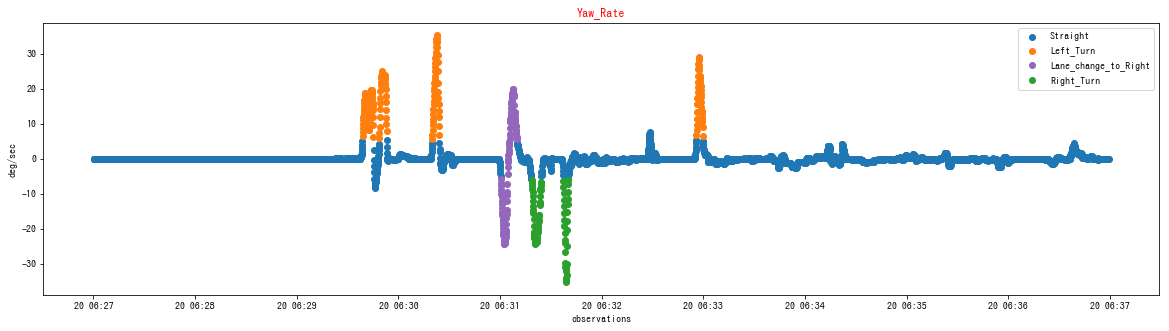

In [8]:
# color map
cmap = plt.get_cmap("tab10")
color_dict = {"Straight":cmap(0), "Left_Turn":cmap(1), "Right_Turn":cmap(2),
             "Lane_change_to_Right":cmap(3), "Lane_change_to_Right":cmap(4),
             "Curvy_Road":cmap(5)}

fig,ax = plt.subplots(1,1,figsize = (20,5))
ax.set_title('Yaw_Rate',color = 'red')
ax.set_ylabel('deg/sec')
ax.set_xlabel('observations')

for name in data_sampled['Turn_status'].unique():
    tmp = data_sampled.loc[data_sampled.Turn_status == name]
    ax.plot(tmp.index, tmp['Yaw_Rate'], marker='o', linestyle='', label=name,
           color=color_dict[name])
    
ax.legend()

上記の10分間のデータでは、車線変更と思しき旋回が1回、右左折と思しき旋回が数回検出された。

## 右左折/車線変更と思われる旋回のうち、単なるカーブ走行であったものを検出

In [9]:
data_sampled.columns

Index(['Yaw_Rate', 'Steering_Wheel_Absolute_Angle', 'Vehicle_Speed',
       'Turn_status'],
      dtype='object')

In [10]:
state = ''
W = []
Ts = 0.1
W_lane = 3.65 # meters of lane
W_curve = 23 # meters of lane
H = []

data_sampled_revised = data_sampled.copy()
data_sampled_revised["Vehicle_Speed_mps"] = data_sampled_revised["Vehicle_Speed"] * 1000 / (60 * 60)

for i in range(data_sampled_revised.shape[0]):
    if state == "":
        # Turn開始
        if data_sampled_revised.Turn_status[i] == 'Left_Turn' or \
            data_sampled_revised.Turn_status[i] == 'Right_Turn':
            start_turn = i
            state = 'Turn'
            
        # 車線変更開始
        if data_sampled_revised.Turn_status[i] == 'Lane_change_to_Left' or \
            data_sampled_revised.Turn_status[i] == 'Lane_change_to_Right':
            start_lane_change = i
            state = 'Lane_change'
    
    # Turn終了
    elif state == 'Turn' and data_sampled_revised.Turn_status[i] != 'Left_Turn' and \
        data_sampled_revised.Turn_status[i] != 'Right_Turn':
        
        Ys = np.radians(data_sampled_revised["Yaw_Rate"].iloc[start_turn:i] * Ts) # 瞬間角度変化
        Vs = data_sampled_revised["Vehicle_Speed_mps"].iloc[start_turn:i] * Ts # 瞬間速度
        
        horizontal_moves = np.sin(Ys.cumsum()) * Vs
        horitonzal_move_sum = sum(horizontal_moves)
        W.append((horitonzal_move_sum, state))
        
        # 横移動が一定値よりも大きい場合は、曲がった道路と判定
        if abs(horitonzal_move_sum) > W_curve:
            data_sampled_revised.iloc[start_turn:i]['Turn_status'] = 'Curvy_Road'
        Ys, Vs = [], []
        state = ''
            
    # 車線変更終了
    elif state == 'Lane_change' and data_sampled_revised.Turn_status[i] != 'Lane_change_to_Left' \
        and data_sampled_revised.Turn_status[i] != 'Lane_change_to_Right':
        
        Ys = np.radians(data_sampled_revised["Yaw_Rate"].iloc[start_turn:i] * Ts) # 瞬間角度変化
        Vs = data_sampled_revised["Vehicle_Speed_mps"].iloc[start_turn:i] * Ts # 瞬間速度
        horizontal_moves = np.sin(Ys.cumsum()) * Vs
        horitonzal_move_sum = sum(horizontal_moves)
        W.append((horitonzal_move_sum, state))
        
        # 横移動が一定値よりも大きい場合は、曲がった道路と判定
        if abs(horitonzal_move_sum) > W_lane:
            data_sampled_revised.iloc[start_lane_change:i]['Turn_status'] = 'Curvy_Road'
        Ys, Vs = [], []
        state = '' 

/Users/localadmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
W

[(6.558130903790807, 'Turn'),
 (5.289472765296175, 'Turn'),
 (6.559650006063201, 'Turn'),
 (34.2311538831425, 'Lane_change'),
 (-8.382887978547812, 'Turn'),
 (-7.560778991744213, 'Turn'),
 (18.24877527407419, 'Turn')]

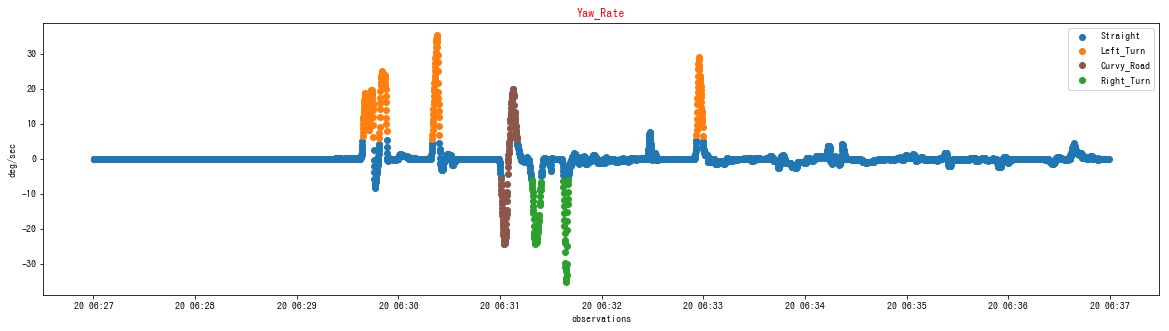

In [12]:
fig,ax = plt.subplots(1,1,figsize = (20,5))
ax.set_title('Yaw_Rate',color = 'red')
ax.set_ylabel('deg/sec')
ax.set_xlabel('observations')

for name in data_sampled_revised['Turn_status'].unique():
    tmp = data_sampled_revised.loc[data_sampled_revised.Turn_status == name]
    ax.plot(tmp.index, tmp['Yaw_Rate'], marker='o', linestyle='', label=name,
           color=color_dict[name])
    
ax.legend()

上記の10分間のデータでは、一つ前で検出された車線変更は、横移動距離が大きく、曲がった道路であるという検出結果となった。

## ジオマップと比較/検証

In [13]:
samplingFrequency = 10 # 今回のデータは100ms間隔のサンプリングなので、サンプリング周波数は10Hz

In [14]:
dfCoordinate = data_sampled_revised[['Steering_Wheel_Absolute_Angle', 'Yaw_Rate', 'Vehicle_Speed', 
                            'Turn_status']]

dfCoordinate['Vehicle_Speed_mps'] = dfCoordinate['Vehicle_Speed'] * 1000 / (60 * 60)
dfCoordinate['cumu_yaw_rate'] = dfCoordinate.Yaw_Rate.cumsum() / samplingFrequency
dfCoordinate['cumu_Steering_Wheel_Absolute_Angle'] =  \
    dfCoordinate.Steering_Wheel_Absolute_Angle.cumsum() / samplingFrequency

dfCoordinate['cos'] = np.cos(np.radians(dfCoordinate['cumu_yaw_rate'])) 
dfCoordinate['sin'] = np.sin(np.radians(dfCoordinate['cumu_yaw_rate'])) 

vecSpeed100ms = dfCoordinate['Vehicle_Speed_mps'] / samplingFrequency

dfCoordinate['relative_x']   = dfCoordinate['cos'] * vecSpeed100ms
dfCoordinate['relative_y']   = dfCoordinate['sin'] * vecSpeed100ms
dfCoordinate['coordinate_x'] = dfCoordinate['relative_x'].cumsum()
dfCoordinate['coordinate_y'] = dfCoordinate['relative_y'].cumsum()

In [15]:
def mapPlotwithCurve(df, figsize=(10, 10)):
    df = df.dropna()
    fig,ax = plt.subplots(1,1,figsize = figsize)
    ax.set_title('Geomap with turn/lane change status', color = 'red')
    ax.set_ylabel('x[m]')
    ax.set_xlabel('y[m]')

    for name in df['Turn_status'].unique():
        tmp = df.loc[df.Turn_status == name]
        plt.scatter(tmp.coordinate_x, tmp.coordinate_y, 
                    s=1, label=name, color=color_dict[name])
    ax.legend()
    ax.text(df.coordinate_x.iloc[0], df.coordinate_y.iloc[0], "Start", size=12)

In [16]:
dfCoordinate.Turn_status.unique()

array(['Straight', 'Left_Turn', 'Curvy_Road', 'Right_Turn'], dtype=object)

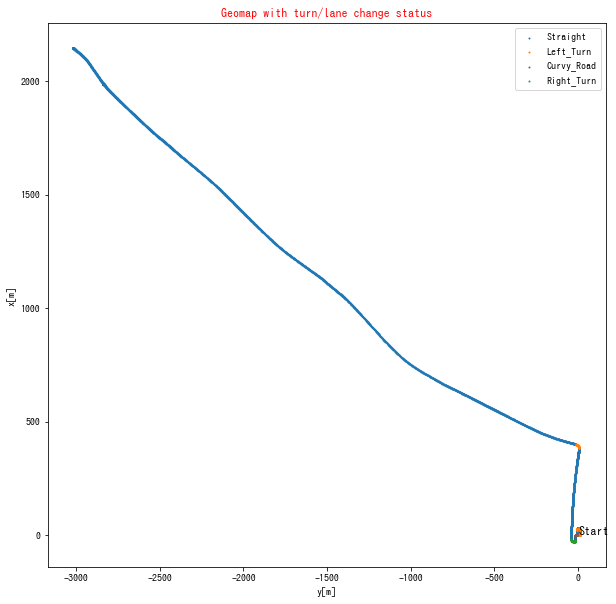

In [17]:
mapPlotwithCurve(dfCoordinate) # 全体

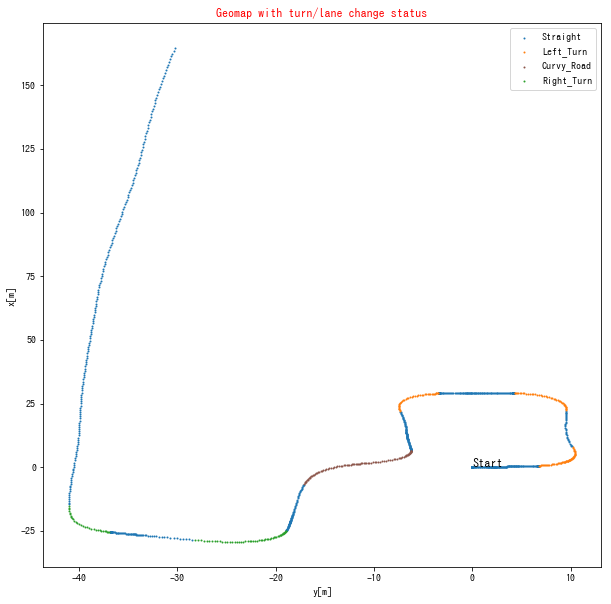

In [18]:
# 最初の5分
mapPlotwithCurve(dfCoordinate.iloc[:10*60*5])

途中の曲がりくねった道が、本当にそのような道なのか、連続した左折→右折だったのかは地図や動画等での確認を要する。

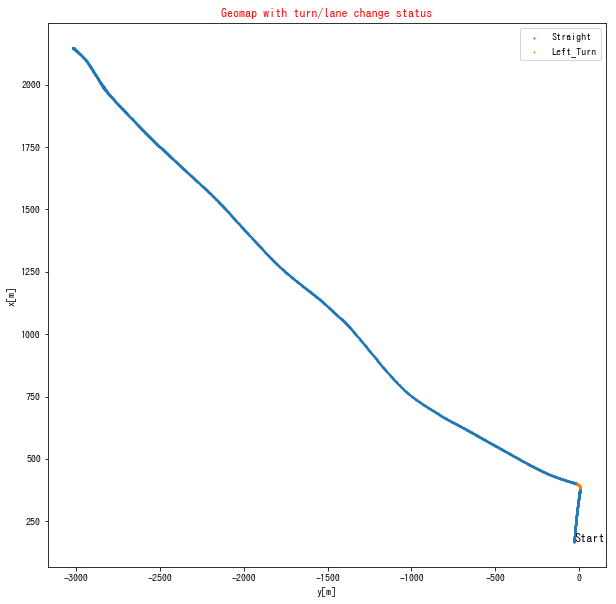

In [19]:
# 後の5分
mapPlotwithCurve(dfCoordinate.iloc[10*60*5:])